In [10]:
import os
import pandas as pd

current_dir = os.getcwd()
final_path = os.path.join(current_dir, '..', 'data', 'final', 'final.csv')
selected_path = os.path.join(current_dir, '..', 'data', 'final', 'selected.csv')

final_df = pd.read_csv(final_path)
selected_df = pd.read_csv(selected_path).values

### Przygotowanie danych

In [11]:
from util import prepare_final

final_df = prepare_final(final_df)

final_df.head()

,premium_user,popularity_mean,popularity_std,popularity_min,popularity_max,duration_ms_mean,duration_ms_std,duration_ms_min,duration_ms_max,explicit_ratio,...,q,r,s,t,u,v,w,x,y,z
0,False,-0.997069,-0.995204,-0.319064,-0.994713,-1.059379,-0.409611,-0.430490,-0.491912,-1.065425,...,0,1,0,1,1,0,1,0,0,0
1,False,1.066575,0.740434,2.270742,0.713372,0.661699,-0.043242,1.994549,-0.098518,0.176852,...,0,1,0,1,0,1,1,0,0,0
2,False,-0.997069,-0.995204,-0.319064,-0.994713,-1.429353,-0.963033,0.339053,-0.735753,-0.814081,...,0,1,1,0,1,0,0,0,0,0
3,False,-0.997069,-0.995204,-0.319064,-0.994713,-1.192440,-0.607767,-1.304843,-0.491912,-0.613005,...,0,1,0,1,1,1,1,0,1,0
4,False,1.056186,1.104850,0.544205,0.968310,0.678373,-0.770022,0.842162,-0.812626,2.439812,...,0,1,1,1,1,0,0,0,0,0


In [12]:
from sklearn.model_selection import train_test_split

X = final_df.drop('premium_user', axis=1).values
y = final_df['premium_user'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_selected, X_test_selected, _, _ = train_test_split(selected_df, y, test_size=0.2, random_state=42)

### Klasyfikator SVM

Szukanie parametrów

In [17]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear']
}

svc = SVC(probability=True)

grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=2, n_jobs=-1, verbose=2, scoring='roc_auc')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters found: ", best_params)
print("Best cross-validation score: ", best_score)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
Best parameters found:  {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation score:  0.855631564701578


Uczenie

In [18]:
clf = SVC(kernel='linear', probability=True, gamma='scale', C=10.0)
clf.fit(X_train_selected, y_train)

y_pred = clf.predict(X_test_selected)
y_pred_proba = clf.predict_proba(X_test_selected)[:, 1]

Accuracy: 0.77
ROC AUC: 0.84
Precision: 0.81
Recall: 0.60
F1 Score: 0.69


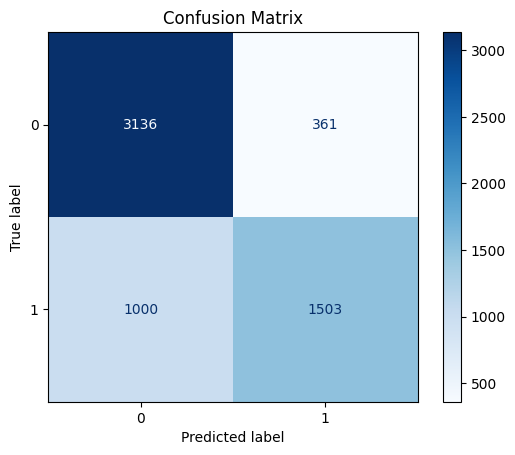

In [14]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

accuracy = metrics.accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

roc_auc = metrics.roc_auc_score(y_test, y_pred_proba)
print(f'ROC AUC: {roc_auc:.2f}')

precision = metrics.precision_score(y_test, y_pred)
print(f'Precision: {precision:.2f}')

recall = metrics.recall_score(y_test, y_pred)
print(f'Recall: {recall:.2f}')

f1 = metrics.f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.2f}')

cm = metrics.confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Save models

In [19]:
import joblib

model_path = os.path.join(current_dir, 'trained', 'svm_selected_model.joblib')

joblib.dump(clf, model_path)

['c:\\_prog\\vm_shared\\Account-Classifier\\models\\trained\\svm_selected_model.joblib']